Imports

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.impute import KNNImputer

Load Data

In [2]:
df = pd.read_csv('.\\CreditPrediction.csv')

#Clear Duplicated Rows
df.drop_duplicates(inplace = True)

# Remove null rows
df.dropna(how='all', inplace = True)

# Remove null columns
df.dropna(axis=1, how='all', inplace = True)

# delete CLIENTNUM
df.drop('CLIENTNUM', axis=1, inplace=True)

print("Training Data shape:", df.shape)
print(df.head(5))


Training Data shape: (10132, 18)
   Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0          45.0      M                3     High School        Married   
1          49.0      F                5        Graduate            NaN   
2          51.0      M                3        Graduate        Married   
3          40.0      F                4     High School            NaN   
4          40.0      M                3      Uneducated        Married   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0     $60K - $80K          Blue            39.0                       5.0   
1  Less than $40K          Blue            44.0                       6.0   
2    $80K - $120K          Blue            36.0                       4.0   
3  Less than $40K          Blue            34.0                       3.0   
4     $60K - $80K           NaN            21.0                       5.0   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Li

Fill Unkown data with NaN

In [3]:
mask = (df['Education_Level'] == 'Unknown')
df.loc[mask, 'Education_Level'] = np.nan


mask = (df['Income_Category'] == 'Unknown')
df.loc[mask, 'Income_Category'] = np.nan


mask = (df['Marital_Status'] == 'Unknown')
df.loc[mask, 'Marital_Status'] = np.nan


Encode Categorical Data

In [4]:

Income_category_Mapping ={
    'Less than $40K' : 0, 
    '$40K - $60K' : 50000, 
    '$60K - $80K' : 70000, 
    '$80K - $120K'  : 100000, 
    '$120K +' : 300000, 
}


Marital_status_mapping = {

    'Married' : 5000,
    'Single' : 3000,
    'Divorced' : 0
}

Card_Category_mapping = {
    'Blue'  : 10000,
    'Silver' : 20000,
    'Gold' : 30000,
    'Platinum' : 40000
}


education_level_mapping = {
    'Uneducated' : 0,
    'High School' : 10000,
    'College' : 20000,
    'Graduate' : 40000,
    'Post-Graduate' : 60000,
    'Doctorate' : 70000
}


Gender_mapping = {
    'M' : .5,
    'F' : .4
    }


df['Education_Level'] = df['Education_Level'].map(education_level_mapping)
df['Gender'] = df['Gender'].map(Gender_mapping)
df['Income_Category'] = df['Income_Category'].map(Income_category_Mapping)
df['Marital_Status'] = df['Marital_Status'].map(Marital_status_mapping)
df['Card_Category'] = df['Card_Category'].map(Card_Category_mapping)

Remove Age Outliers

In [5]:
Q1 = df['Customer_Age'].quantile(0.1)
Q3 = df['Customer_Age'].quantile(0.99)
IQR = Q3 - Q1

df = df[~((df['Customer_Age'] < (Q1 - 1.5 * IQR))
           |(df['Customer_Age'] > (Q3 + 1.5 * IQR)))]


Feature Selection

In [6]:
df.drop('Gender', axis=1, inplace=True)
df.drop('Months_Inactive_12_mon', axis=1, inplace=True)
df.drop('Dependent_count', axis=1, inplace=True)
df.drop('Marital_Status', axis=1, inplace=True)

Spilit df to train and test

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = df.drop('Credit_Limit', axis=1)  # Features
y = df['Credit_Limit']  # Target

train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)


print("Data Frame shape:", df.shape)
print(f"X Train shape: {train_images.shape}   |    y Train shape: {train_labels.shape}")
print(f"X Test shape: {test_images.shape}    |   y Test shape: {test_labels.shape}")
print(type(train_images), type(train_labels))


Data Frame shape: (10115, 14)
X Train shape: (8092, 13)   |    y Train shape: (8092,)
X Test shape: (2023, 13)    |   y Test shape: (2023,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


Fill Test Missed Values With KNNImputer

In [9]:
from sklearn.impute import KNNImputer

# Create the KNN imputer
imputer = KNNImputer(n_neighbors=8, weights='uniform', metric='nan_euclidean')


# Fit and transform the dataset
train_images = imputer.fit_transform(train_images)
test_images = imputer.transform(test_images)

Scale Data

In [11]:
scaler = StandardScaler()

# Fit the scaler
scaler.fit(train_images)

# Transform
train_images = scaler.transform(train_images)
test_images = scaler.transform(test_images)

train_images_df = pd.DataFrame(train_images)

print(type(train_images), type(train_labels))
print(train_images_df.head(5))


<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
         0         1         2         3         4         5         6   \
0  1.574676  1.751075 -0.811973 -0.282418  2.273467 -1.798206  0.497976   
1  0.082198  0.705433 -0.811973  2.916641  0.511361 -1.798206 -0.408168   
2 -1.285907  0.705433 -0.156282 -0.282418 -0.999017  0.775541  0.497976   
3 -2.032145  0.705433 -0.811973 -0.282418  0.007902 -0.511332 -0.408168   
4 -1.534653  0.705433 -0.156282  2.916641 -0.873152  1.418978 -0.408168   

         7         8         9         10        11        12  
0 -1.421395 -0.689043  0.147597  0.301785  0.193654 -0.991678  
1  1.660897  0.185514  1.206463  1.194267 -0.204752 -0.173111  
2  0.872261 -0.905380 -0.728968 -0.718195 -0.229915  0.000744  
3  0.566114 -0.504925 -0.747462 -0.590697 -1.823539  1.311900  
4 -0.597246 -0.178117 -0.517900 -0.038208 -0.779296 -0.911994  


Model Implemation

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


model = RandomForestRegressor(n_estimators=98, max_depth=10, random_state=42)


# Fit
model.fit(train_images, train_labels)

# Predict
y_pred = model.predict(test_images)


# Calculate R²
r2 = r2_score(test_labels, y_pred)

# Calculate (MSE)
mse = mean_squared_error(test_labels, y_pred)

# Convert R² error to percentage
r2_percentage = r2 * 100

# Print the performance metrics
print(f'Mean Squared Error (MSE): {mse:,.2f}')
print(f'R² Error: {r2_percentage:.2f}%')

print('y prediction samples: ',y_pred)

KeyboardInterrupt: 

Model Plots

Feature Importance Plot:

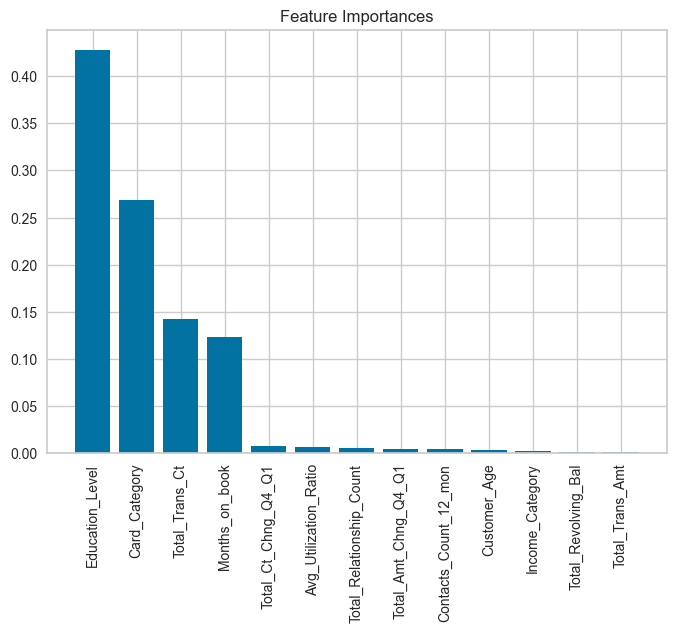

In [ ]:
import matplotlib.pyplot as plt


train_images_columns = [
    'Customer_Age',
    'Income_Category',
    'Card_Category',
    'Months_on_book',
    'Contacts_Count_12_mon',
    'Total_Revolving_Bal',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Avg_Utilization_Ratio',
    'Total_Ct_Chng_Q4_Q1',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Relationship_Count',
    'Education_Level',
]
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
names = [train_images_columns[i] for i in indices]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(train_images.shape[1]), feature_importances[indices])
plt.xticks(range(train_images.shape[1]), names, rotation=90)
plt.show()


Actual vs Predicted Plot:

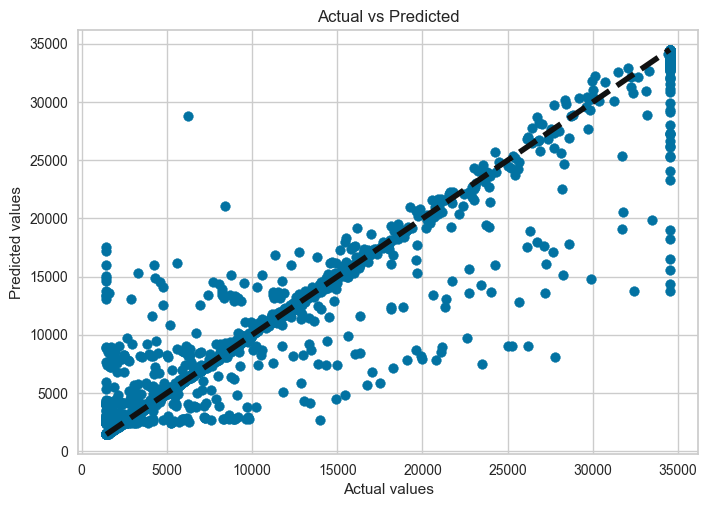

In [ ]:
plt.scatter(test_labels, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.show()


Prediction Error Plot

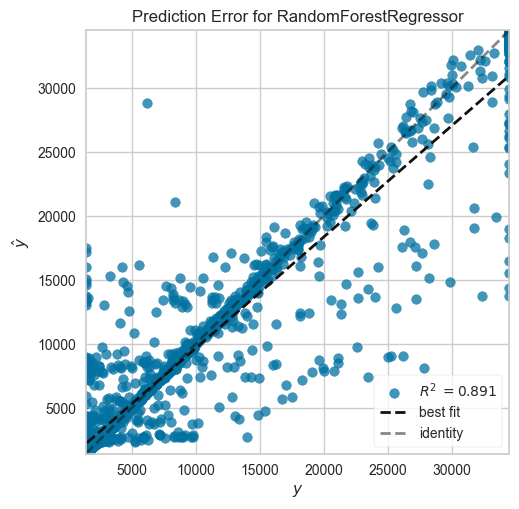

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
#This plot helps to understand the variance of the model predictions
# by comparing the true outcomes to the predicted outcomes

from yellowbrick.regressor import PredictionError
visualizer = PredictionError(model)
visualizer.fit(train_images, train_labels)
visualizer.score(test_images, test_labels)  
visualizer.show()


Learning Curve:

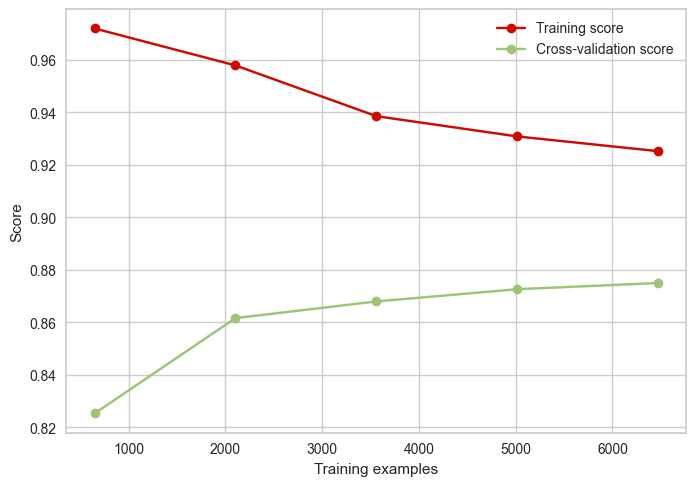

In [ ]:
#  It is a tool to find out how much benefit the model gets from adding more training data
#         and whether the estimator suffers more from a variance error or a bias error.


from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, train_images, train_labels, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()
